<a href="https://colab.research.google.com/github/esolisc/Introd_Ciencias_Datos_Biomed/blob/main/Clase_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


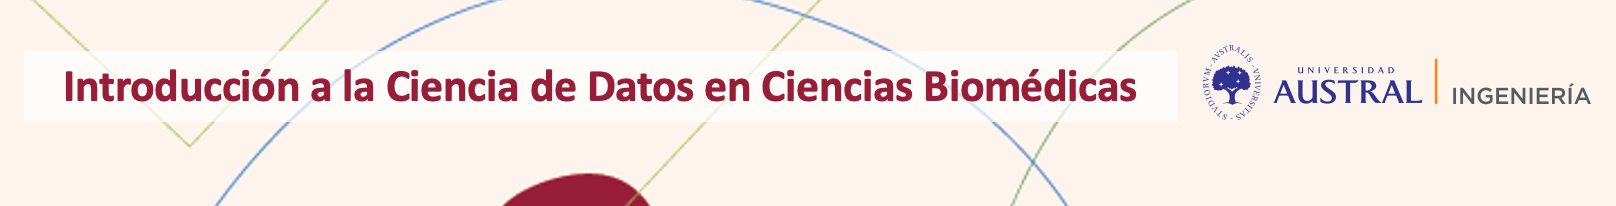

# Introducción:



En esta clase se utilizará un dataset de 381 pacientes.

La base de datos fue obtenida a partir de la publicación de Debernardi y colaboradores [[manuscrito](https://pubmed.ncbi.nlm.nih.gov/33301466/)].

La misma cuenta con las siguientes variables:
- Demográficas:
  
  * edad (años)
  * sexo

- Biomarcadores urinarios:

  * creatinina [mg/ml]
  * LYVE1 [ng/ml]
  * REG1B [ng/ml]
  * TFF1 [ng/ml]

- Diagnóstico:

  * sanos
  * con alguna condición benigna
  * PDAC

Los datos fueron generados en 4 centros de investigación. En este trabajo se decidió utilizar los datos de pacientes cuyo diagnóstico era “normal” (sanos) o “maligno” (PDAC), conformando una base de datos de 381 registros.

La base de datos original presenta otros atributos que no fueron utilizados en este análisis, como ser el grado de avance de la enfermedad y otros biomarcadores urinarios. La primera variable se descartó dado que se prevé que dicha información no estaría disponible en el momento de implementación del modelo. Por otro lado, no se utilizaron los otros biomarcadores presentes en la base de datos original, ya que los mismos estaban representados en apenas un 50% de los registros.

Se implementarán los modelos de:

- Regresión lineal múltiple
- Regresión logística
- Naive Bayes
- KNN
- Árboles de decisión

# Preprocesamiento

### Importo librerías y datos

In [ ]:
# Librerías generales
from six import StringIO
from IPython import display
from IPython.display import Image
import pydotplus

import pandas as pd
import numpy as np

# Librerías generales de graficación
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

# Preprocesamiento
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Métricas
from sklearn.metrics import precision_recall_fscore_support,accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, ConfusionMatrixDisplay, silhouette_score,classification_report

# Modelado
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

# Styling
plt.style.use('ggplot')

In [ ]:
# url donde tengo colgado el dataset (pancreas.csv)
url= 'https://raw.githubusercontent.com/FabianaRossi/Data/main/pancreas.csv'
df= pd.read_csv(url)

### Exploración inicial

In [ ]:
# con la función head se muestran las primeras 5 filas del dataframe.
# Si dentro de los paréntesis se indica un número, entonces se mostraran tantas filas como el número lo indique
df.head()

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


In [ ]:
# Si se escribe df.columns se muestran los nombres de las columnas del dataframe
# Si yo asigno una lista de nombres (como la que está escrita en español entre "[ ]") a df.columns entonces estoy accediendo a los tìtulos de las columnas y las estoy nombrando
df.columns= ['id','cohorte','origen','edad','sexo','diagnosis','estadio','diagnosis_benigno','plasma_CA19_9','creatinina','LYVE1','REG1B','TFF1','REG1A']

In [ ]:
# .loc me permite seleccionar una parte del dataframe. En este caso le digo que seleccione
# todas las filas cuando la columna diagnosis es igual a 1 o (el símbolo para indicar "o" es "|") 3

# Elijo normal y maligno
df= df.loc[(df['diagnosis']==1)|(df['diagnosis']==3)]
df.head()

,id,cohorte,origen,edad,sexo,diagnosis,estadio,diagnosis_benigno,plasma_CA19_9,creatinina,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


In [ ]:
# Renombro 1=normal, 3=maligno
# uso la función where de la librerìa numpy (np.where) y le pido que en aquellos casos donde la columna diagnosis fuera 1, que ponga 'normal'
# si no... que ponga maligno

# Si hubiera puesto "np.where(df['diagnosis']==1, 'normal','condicion1')" esto implicaría que en donde diagnosis==1 reescribe como normal, y sino, pone "condicion1"
df['diagnosis'] = np.where(df['diagnosis']==1, 'normal','maligno')

In [ ]:
# Me quedo sólo con algunas columnas utilizando doble [[ ]]
data = df[["edad", "sexo", "diagnosis", "creatinina", "LYVE1", "REG1B", "TFF1"]]

In [ ]:
# acá estoy printeando un string (texto), que está entre '' .
# para realizar operaciones de suma con strings, sí o sí le tengo que sumar otro string
# acá le estoy sumando el largo de los índices únicos
# data.index.unique me busca los índices únicos de data. "len" me calcula el tamaño de esos índices únicos (los cuenta)
# finalmente "str" me sirve para pasar a string ese número calculado anteriormente
print('Número de registros: ' + str(len(data.index.unique())))

Número de registros: 381


In [ ]:
# Le pido que me calcule el número de veces que aparece cada elemento/valor de la columna diagnosis del dataframe llamado data
data['diagnosis'].value_counts()

maligno    198
normal     183
Name: diagnosis, dtype: int64

In [ ]:
# Descripción de variables (ojo, sólo las numéricas hace.. si tenés categóricas, el método .describe no las ve)
data.describe()

,edad,creatinina,LYVE1,REG1B,TFF1
count,381.000000,381.000000,381.000000,381.000000,381.000000
mean,61.425197,0.852436,3.543288,137.992804,671.783173
std,12.354534,0.638349,3.656345,224.541415,1146.698858
min,26.000000,0.067860,0.000129,0.001104,0.005293
25%,53.000000,0.361920,0.174381,13.404489,39.056000
50%,62.000000,0.712530,2.225879,47.699981,274.718400
75%,70.000000,1.131000,5.875759,150.056000,811.308000
max,89.000000,4.116840,15.270520,1403.897600,13344.300000


In [ ]:
# Descripción de variables numérica - missing data. Parecido a lo anterior, con método ".info", pero que además me muestra missing
print(data.info(verbose=True, show_counts=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381 entries, 0 to 588
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   edad        381 non-null    int64  
 1   sexo        381 non-null    object 
 2   diagnosis   381 non-null    object 
 3   creatinina  381 non-null    float64
 4   LYVE1       381 non-null    float64
 5   REG1B       381 non-null    float64
 6   TFF1        381 non-null    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 31.9+ KB
None


---
# Análisis Exploratorio de datos

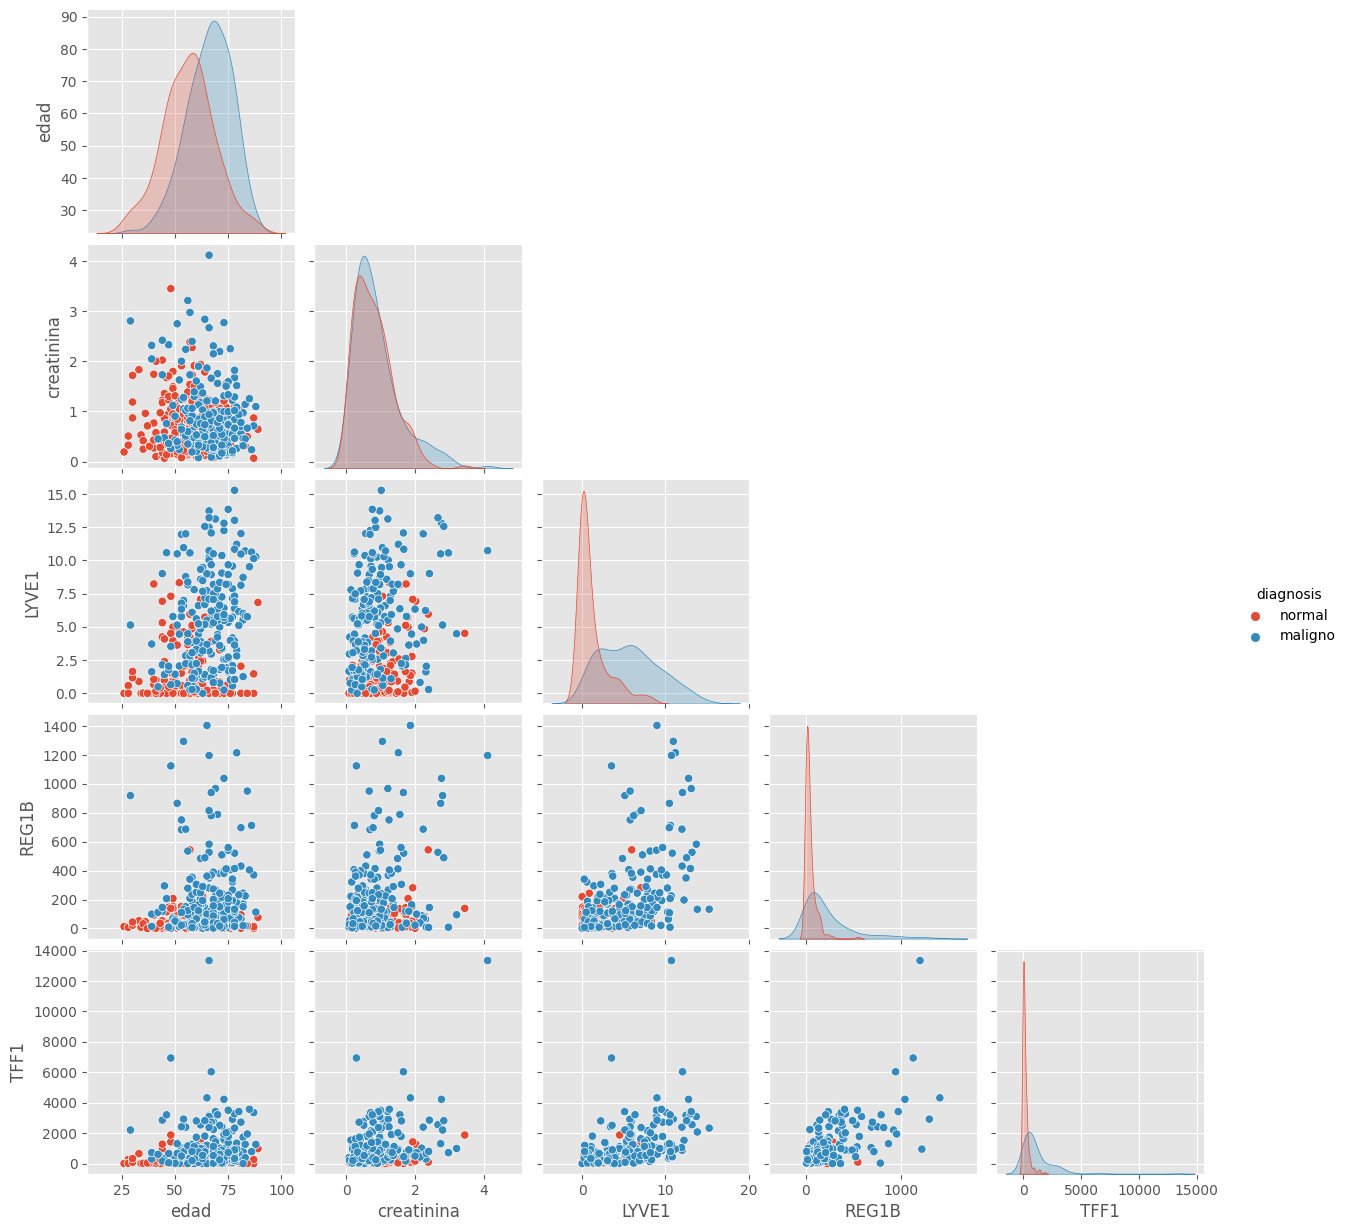

In [ ]:
# Análisis pairplot

# primero le saco los na con la función .dropna. Los parámetros de esa función (lo que está entre paréntesis)
# indica que borre por filas (axis=0), y del modo "any"... es decir, si ve cualquier cero, borra la fila entera
data_pairplot= data.dropna(axis=0, how='any')
g = sns.pairplot(data_pairplot, hue = 'diagnosis')

# Remoción de triángulo superior (para visualización)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

plt.show()

# Vuelvo a estilo ggplot2 (ggplot2 es una librería de R, otro lenguaje de programación, que tiene grafiquitos más lindos)
plt.style.use('ggplot')

<ipython-input-13-2409b3b0ed58>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr())


<Axes: >

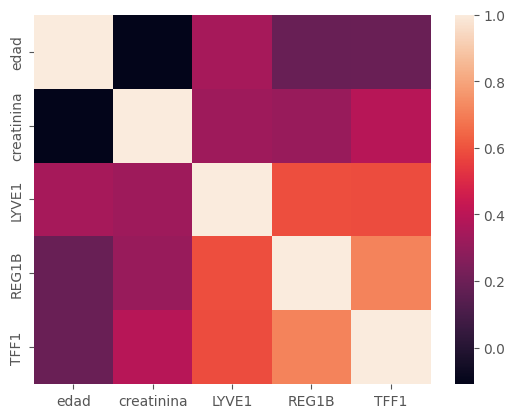

In [ ]:
# Correlograma. "sns" es el acrónimo de la librería seaborn que importé más arriba.
# Yo puse "import seaborn as sns". Si hubiera escrito "import seaborn as xyz", entonces para
# dibujar el correlograma debería haber escrito "xyz.heatmap(data.corr())" [no tiene mucho sentido!! cualquier
# persona que conozca del lenguaje python sabe que sns es seaborn, por uso frecuente]
sns.heatmap(data.corr())

---
# Modelos

CONCEPTO IMPORTANTE:

Se debe evitar el overfitting (que el modelo aprenda muy bien a predecir los datos de entrenamiento, pero le vaya muy mal con nuevos datos)

En general, modelos simples _"overfittean"_ menos, pero les va peor. Modelos más complejos predicen mejor, pero tienden a _"overfittear"_

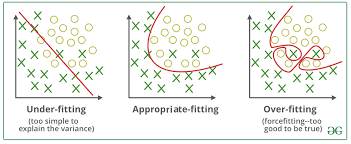

## Regresión lineal simple y múltiple

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

En una regresión existe una variable dependiente y que puede modelarse con un modelo de la forma:

```y= bo + b1.x1 + (...) + e```

La variable dependiente (y) debe ser contínua, pero las regresoras (x1, x2...) pueden ser contínuas, discretas o categóricas.




* **Simple**


In [ ]:
# np es el acrónimo de numpy. Cada vez que escriba "np", está llamando a la librería numpy.
# En este punto estoy haciendo un array (un vector --> lista de números [1,1,1,2,3,4,45,67,8,4] de la columna TFF1 de data)
# o de la columna REG1B.

# Una de las dos columnas tiene además una función de .reshape. El reshape (-1,1) lo único que hace es que si tengo un vector de 100x1 (100 filas, 1 columna), lo pasa a (1 fila, 100 columnas)
# es el equivalente a "transpose" de Excel (se necesita hacer esto para poder aplicar el modelo de regresión lineal)
x= np.array(data['TFF1']).reshape((-1, 1))
y= np.array(data['REG1B'])

In [ ]:
# genero un modelo (LinearRegression()) que se entrena (fit) con los datos x / y
model = LinearRegression().fit(x, y)

In [ ]:
# calculo R cuadrado.... es el score del modelo que me indica qué tan bien el modelo explica la variabilidad de y
r_sq = model.score(x, y)

In [ ]:
print(f"coefficient of determination: {round(r_sq,2)}")
print(f"intercept: {round(model.intercept_,2)}")
print(f"slope: {model.coef_}")


coefficient of determination: 0.51
intercept: 44.24
slope: [0.13955808]


In [ ]:
# Si quisiera predecir nuevos valores de y, entonces debería hacer un model. predict (nuevos x).... el "model" ya está entrenado y por eso puede predecir sobre nuevas x
y_pred = model.predict(x)

In [ ]:
# Armo figura con plotlyexpress (alias px). Le indico la data, x, y, el título.
fig = px.scatter(data, x = "TFF1", y = "REG1B",
             title= 'Relación entre TFF1 y REG1B',
             opacity=0.8, trendline='ols', trendline_color_override='darkred')
#El gráfico podría terminar acá. Cuando le pongo .update_layout es porque quiero seguir modificando/mejorando cómo luce
fig.update_layout(autosize=False, width=600, height=500, yaxis=dict(showgrid=False), xaxis=dict(showgrid=False), title=dict(x=0.5))
fig.show()

El modo en que se encuentra la recta de mejor ajuste es por el método de ols (ordinary least squares): se minimiza la suma de residuos al cuadrado.

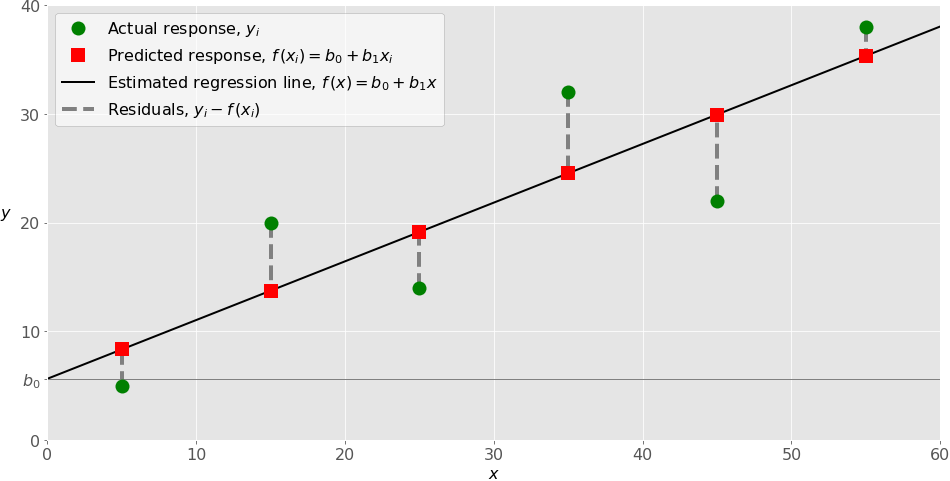

𝑅²: La proporción de la variación en "y" que puede ser explicada por la dependencia con x, utilizando un modelo de regresión determinado. Mayores valores de 𝑅² indica un ajuste mejor, e indica que el modelo puede explicar de mejor manera la variación del output con distintos inputs.


* **Múltiple**

In [ ]:
# mismo que antes pero 3d. Notar que la función anterior de px era .scatter (por scatterplot o gráfico de puntos) y ahora es scatter_3d
fig = px.scatter_3d(data, x = "LYVE1", y = "REG1B", z='TFF1',
             title= 'Relación entre TFF1, REG1B y LYVE1',
             opacity=0.5, color='diagnosis')
fig.update_layout(autosize=False, width=600, height=500, yaxis=dict(showgrid=False), xaxis=dict(showgrid=False), title=dict(x=0.5))
fig.show()

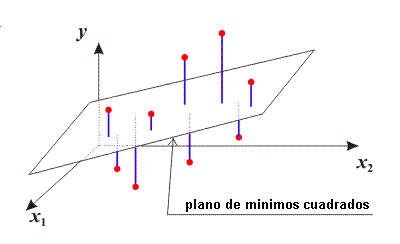

In [ ]:
# acá se hace lo mismo que antes.
x= np.array(data[['TFF1','LYVE1']]).reshape((-1, 2))
y= np.array(data['REG1B'])

In [ ]:
model = LinearRegression().fit(x, y)

In [ ]:
r_sq = model.score(x, y)
print(f"coefficient de determinación (R^2): {round(r_sq,2)}")
print(f"ord origen: {round(model.intercept_,2)}")
print(f"coeficientes: {(model.coef_)}")

coefficient de determinación (R^2): 0.55
ord origen: 7.68
coeficientes: [ 0.10967731 15.98292308]


Interpretación de los resultados:
- La ordenada al origen es igual a 7.68 --> Valor esperado de REG1B para un paciente con valores = 0 de TFF1 y LYVE1 (carece de significado clínico real)
- Los coeficientes son aprox 0,11 y 16.
0,11 --> valor adicional que se agrega a REG1B (y) por cada unidad de TFF1 que se incrementa, asumiendo constantes el resto de las variables.
16 --> cuánto aumenta REG1B (y) por cada aumento en una unidad de LYVE1, asumiento el resto de las variables constantes.

---
## Regresión logística

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

Se utiliza principalmente en problemas de **clasificación** binaria, dada su sencillez y alta explicabilidad.

La idea es encontrar una función de regresión logística (sigmoidea) tal que las respuestas predichas se encuentren cerca del valor de y (0,1).

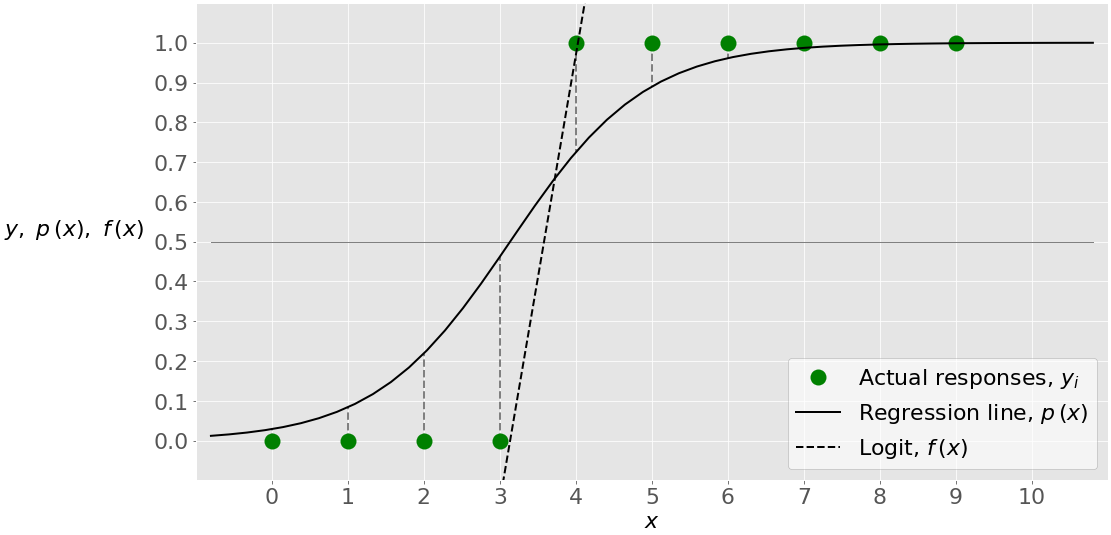

La regresión logística es un clasificador lineal, por lo tanto se utiliza una función lineal 𝑓(𝐱) = 𝑏₀ + 𝑏₁𝑥₁ + ⋯ + 𝑏ᵣ𝑥ᵣ (función logit). Las variables 𝑏₀, 𝑏₁, …, 𝑏ᵣ son los estimadores de los coeficientes de la regresión.

La función de la regresión logística 𝑝(𝐱) es la función sigmoidea de la fc. logit f(x) --> 𝑝(𝐱) = 1 / (1 + exp(−𝑓(𝐱).

𝑝(𝐱) se interpreta como la probabilidad predicha de un dado x cuando es = 1.

1 − 𝑝(𝑥) es probabilidad de que el output sea 0.

#### POSIBLES RESULTADOS EN PROBLEMAS DE CLASIFICACIÓN

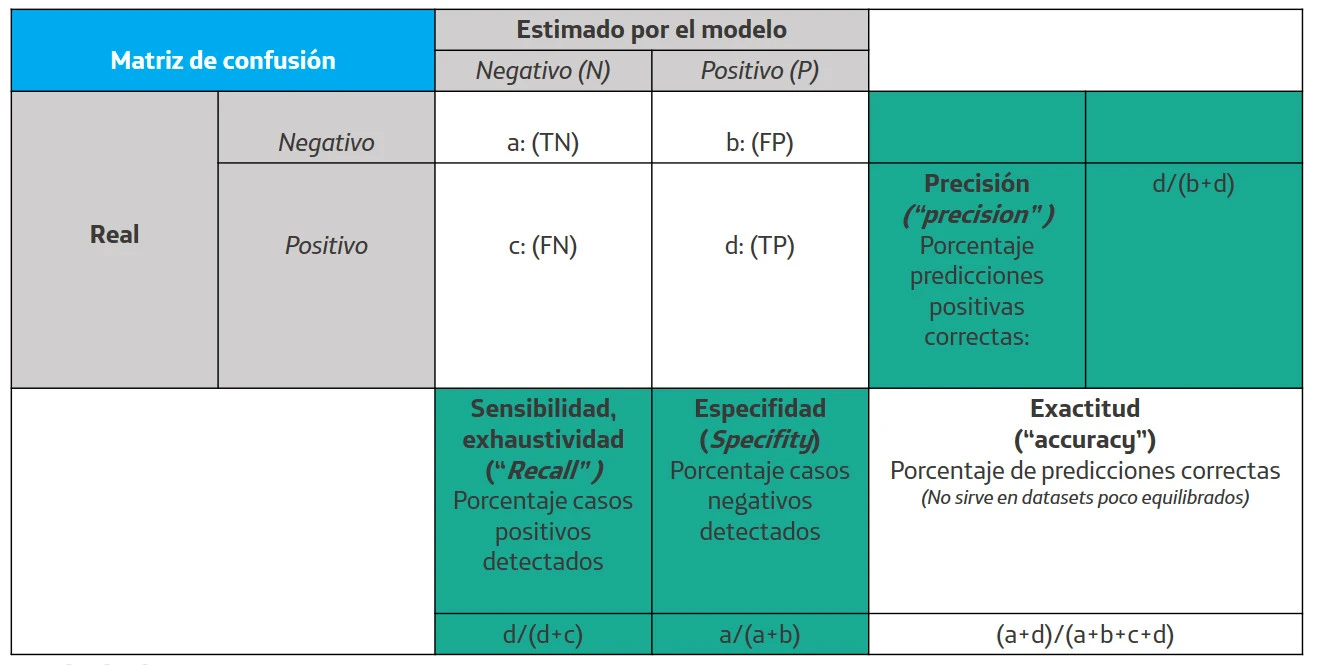

Al igual que la regresión lineal, la regresión logística puede llevarse a cabo con un sólo regresor (x), o con múltiples variables

In [ ]:
data.columns # como indicado anteriormente, la función .columns me indica el nombre de las columnas. Accede a este elemento del dataframe

Index(['edad', 'sexo', 'diagnosis', 'creatinina', 'LYVE1', 'REG1B', 'TFF1'], dtype='object')

**Hago división de datos en entrenamiento (X_train + y_train) - 80% y en datos de prueba (X_test + y_test) - 20%**

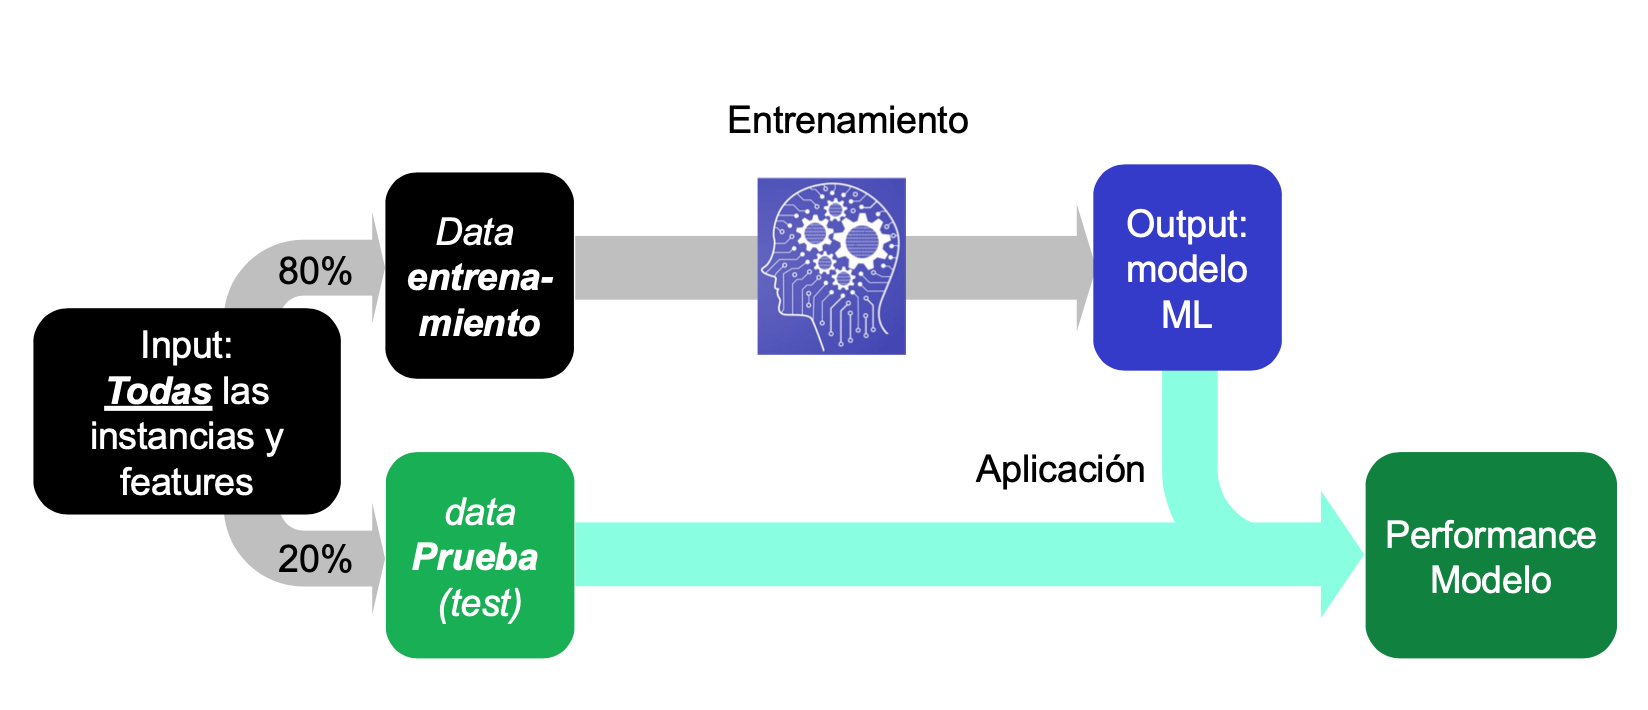

In [ ]:
# defino X e y. data con [[ ]] me permite elegir el nombre de las columnas, que en este caso serán las variables / features de entrada del modelo
X = data[['edad', 'sexo', 'creatinina', 'LYVE1', 'REG1B', 'TFF1']]
# La variable target, que es la que tiene la etiqueta, es la columna diagnosis (que podía ser maligno o benigno)
y= data[['diagnosis']]

In [ ]:
# Acá estoy haciendo la separación de los datos en entrenamiento y prueba
# normalmente cuando se asignaban objetos/variables uno ponía
# a = 1.... y en ese caso se sabía que a varía 1
# acá la asignación de objetos es 4 a la vez, como por ejemplo:
# a, b, c, d = 1, 2, 3, 4 --> esto quiere decir que a vale 1, b vale 2 (...)

# cuando en el siguiente renglon tengo x_train, x_test y demás, estoy definiendo en simultáneo esas 4 cosas.
# esto es porque la función "train_test_split" devuelve 4 elementos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=27)

**Selección de hiperparámetros**
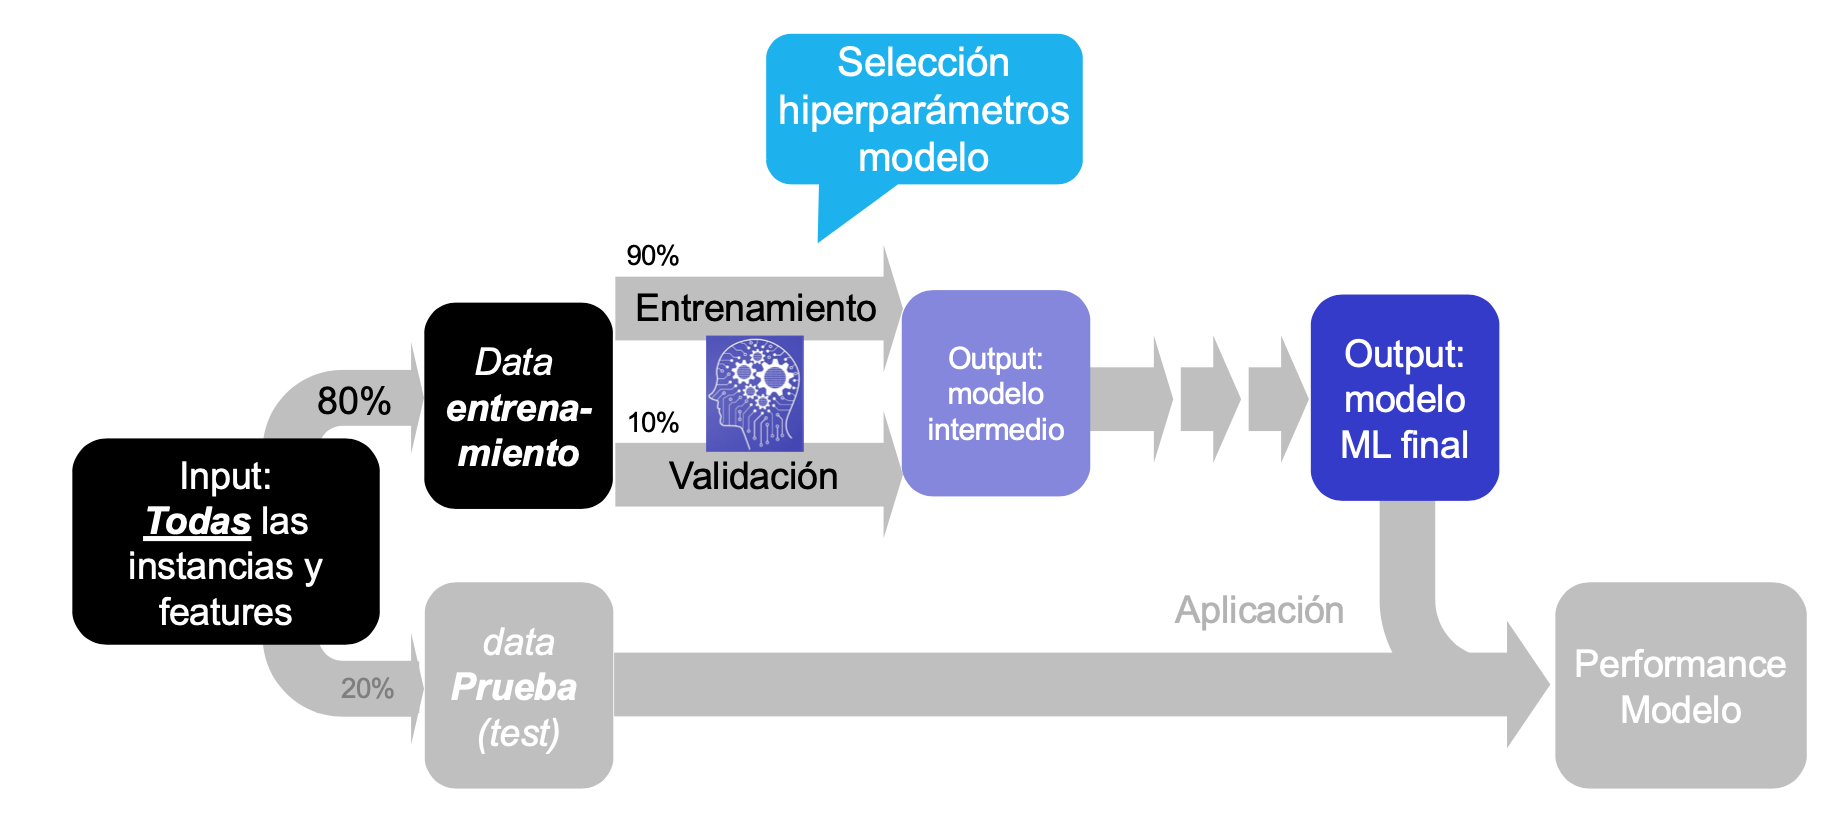

In [ ]:
# defino una lista de parámetros ("perillitas") que quiero optimizar para encontrar el mejor modelo
# primero pongo el parámetro (ejemplo: penalty, C, solver, max_iter) y después pongo una lista de valores posibles para cada uno)
param_grid = [
    {'penalty' : ['l1', 'l2', 'none', 'elasticnet'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

In [ ]:
X_train.columns

Index(['edad', 'sexo', 'creatinina', 'LYVE1', 'REG1B', 'TFF1'], dtype='object')

In [ ]:
scaler = StandardScaler() #  para estandarizar y hacer las escalas entre variables, comparables
scaler.fit(X_train[['creatinina', 'LYVE1', 'REG1B', 'TFF1']]) # entreno al scaler (entrenarlo en este caso es pedirle que calcule, para cada
# variable, la media y sd)

# y después le pido que aplique el scaler entrenado a lass variables 'creatinina', 'LYVE1', 'REG1B', 'TFF1' de X_train.
# para poder utilizar luego esas variables estandarizadas, tengo que guardarlas en un objeto (x_train_scaled, etc)
X_train_scaled = scaler.transform(X_train[['creatinina', 'LYVE1', 'REG1B', 'TFF1']])
X_test_scaled = scaler.transform(X_test[['creatinina', 'LYVE1', 'REG1B', 'TFF1']])

***ESCALADO DE LOS DATOS***

In [ ]:
# Le pido que me haga un array de lo anterior (los modelos necesitan arrays, vectores de números)
X_train_scaled = np.array(X_train_scaled)
X_test_scaled = np.array(X_test_scaled)
y_train= y_train.values.ravel()
y_test= y_test.values.ravel()

In [ ]:
%%capture
# Defino modelo
logreg = LogisticRegression(random_state=16)
# Le pido que me haga una búsqueda de hiperparámetros (GridSearchCV busca entre todas las alternativas posibles que definimos más arriba, es decir
# que busca entre todas las combinaciones posibles. Si uno no quisiera recorrer TODO el espacio de búsqueda, podría hacer un RandomSearch, que busca aleatoriamente
# entre algunas de las combinaciones posibles)
clf = GridSearchCV(logreg, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
# Ahora le pido que entrene el modelo (se llama best_clf el modelo)
best_clf = clf.fit(X_train_scaled,y_train)
# de todos los modelos, el mejor será "best_estimator_"
# lo "llamo" con .best_estimator_ luego de best_clf

In [ ]:
print('Hiperparámetros derivados de la optimización:', best_clf.best_estimator_)

Hiperparámetros derivados de la optimización: LogisticRegression(C=4.281332398719396, max_iter=1000, penalty='l1',
                   random_state=16, solver='saga')


In [ ]:
mejor_modelo= best_clf.best_estimator_

In [ ]:
print('Las clases del modelo son:',mejor_modelo.classes_)
print('Los coeficientes del modelo son:,',mejor_modelo.coef_)
print('El intercept (bo) del modelo es:',mejor_modelo.intercept_)


Las clases del modelo son: ['maligno' 'normal']
Los coeficientes del modelo son:, [[ 0.91451966 -1.6367014  -0.54732853 -2.61470602]]
El intercept (bo) del modelo es: [-1.07023424]


In [ ]:
print (f'Accuracy - : {best_clf.score(X_train_scaled,y_train):.3f}') # el score por default es accuracy

Accuracy - : 0.839


In [ ]:
# Hago nuevas predicciones en test. Lo que el modelo predice tengo que luego contrastarlo con las etiquetas reales del test
# para ver qué tanto le pegó
y_pred = best_clf.predict(X_test_scaled)

              precision    recall  f1-score   support

     maligno       0.92      0.85      0.88        40
      normal       0.85      0.92      0.88        37

    accuracy                           0.88        77
   macro avg       0.88      0.88      0.88        77
weighted avg       0.89      0.88      0.88        77

[[34  6]
 [ 3 34]]


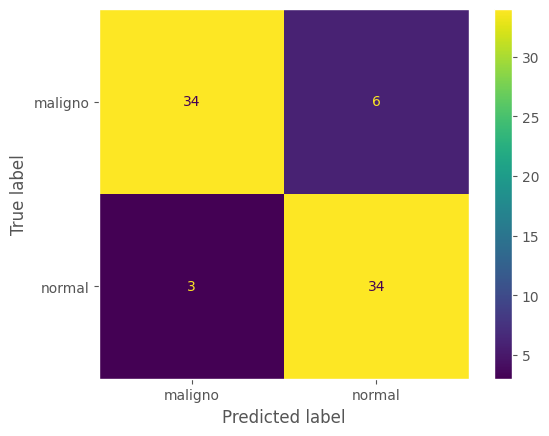

In [ ]:
# Reporte de clasificación
print(classification_report(y_test, y_pred))
# Matriz de confusión (dibujo horrible con [[ ]] )
print(confusion_matrix(y_test, y_pred))
# Le pido que me dibuje un poco más lindo la matriz de confusión
disp=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred),display_labels=best_clf.classes_)
disp.plot()
plt.grid(False)

Frontera de decisión

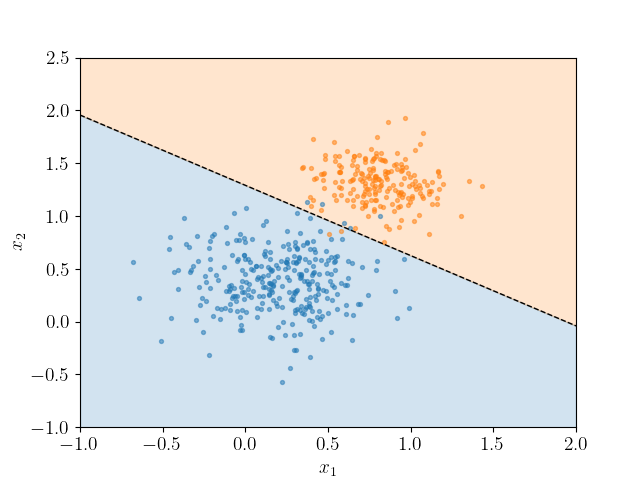

---
## KNN

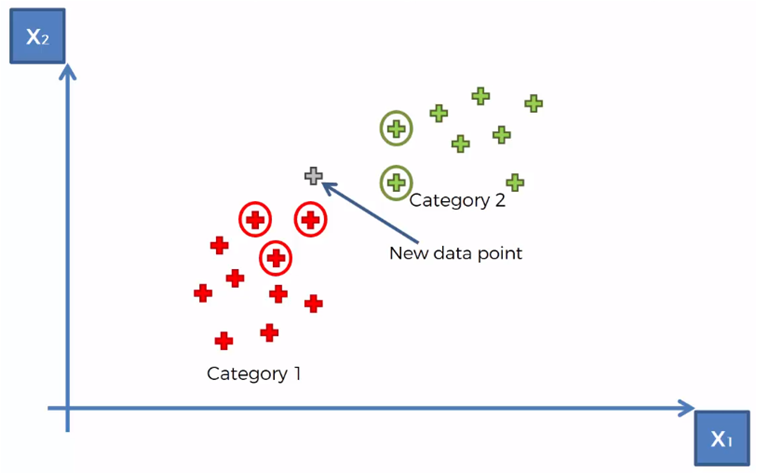

In [ ]:
# primero le pido una lista de números que quiero evaluar
neighbors = np.arange(1,15)  # --> devuelve array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
# Armo vectores vacíos. Por qué? porque tengo que ir probando para los distintos números de vecinos cuál es el accuracy en train y test.
# para 1 vecino, voy a tener 1 valor para train y otro para test. Esos valores los voy a poner en la primera posición de los vectores vacíos
# para 2 vecinos, voy a tener 1 valor de train/test y voy a poner c/u en su lugar, en sus respectivos vectores.
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors): # para cada uno de los vecinos que definí antes, hago esta secuencia de pasos

    # Armo clasificador
    knn = KNeighborsClassifier(n_neighbors=k)
    # entreno ese modelo clasificador
    knn.fit(X_train_scaled, y_train)
    # calculo accuracy train
    train_accuracy[i] = knn.score(X_train_scaled, y_train)
    # calculo accuracy test
    test_accuracy[i] = knn.score(X_test_scaled, y_test)

# y cómo es que voy llenando los vectores vacíos??

# cuando escribo train_accuracy, escribo todo el vector. Cuando escribo train_accuracy[0], estoy accediendo al primer elemento de ese vector únicamente
# cuando escribo "test_accuracy[i] = knn.score(X_test_scaled, y_test)" lo que estoy haciendo es poner en la posición i, el valor de knn.score


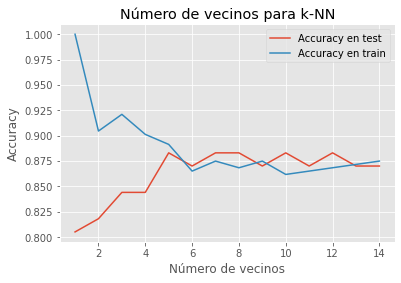

In [ ]:
# plt es el acrónimo de matplotlib (librería de graficacíon)
plt.title('Número de vecinos para k-NN')
plt.plot(neighbors, test_accuracy, label= 'Accuracy en test')
plt.plot(neighbors, train_accuracy, label='Accuracy en train')
plt.legend()
plt.xlabel('Número de vecinos')
plt.ylabel('Accuracy')
plt.show() # fijense que va construyendo la imagen de acapas. primero pone título, después 1 gráfico, después pone otro arriba, después la leyenda (...)

In [ ]:
# idem anterior, pero fijo el número de vecinos en 6
#KNN
knn_model = KNeighborsClassifier(n_neighbors = 6)
# Entrenamiento
knn_model.fit(X_train_scaled, y_train)
# Predicción
prediction = knn_model.predict(X_test_scaled)
# métricas
knn_model.score(X_test_scaled, y_test)

print(classification_report(y_test, prediction))
print(confusion_matrix(y_test, prediction))

              precision    recall  f1-score   support

     maligno       0.86      0.90      0.88        40
      normal       0.89      0.84      0.86        37

    accuracy                           0.87        77
   macro avg       0.87      0.87      0.87        77
weighted avg       0.87      0.87      0.87        77

[[36  4]
 [ 6 31]]


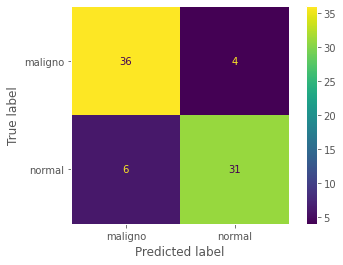

In [ ]:
disp=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, prediction),display_labels=knn_model.classes_)
disp.plot()
plt.grid(False)

Frontera de decisión

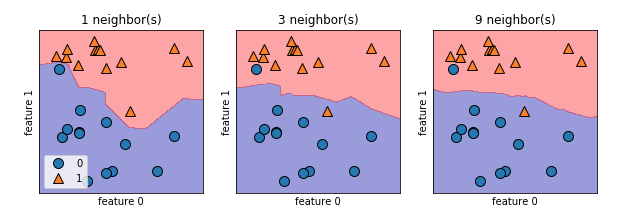

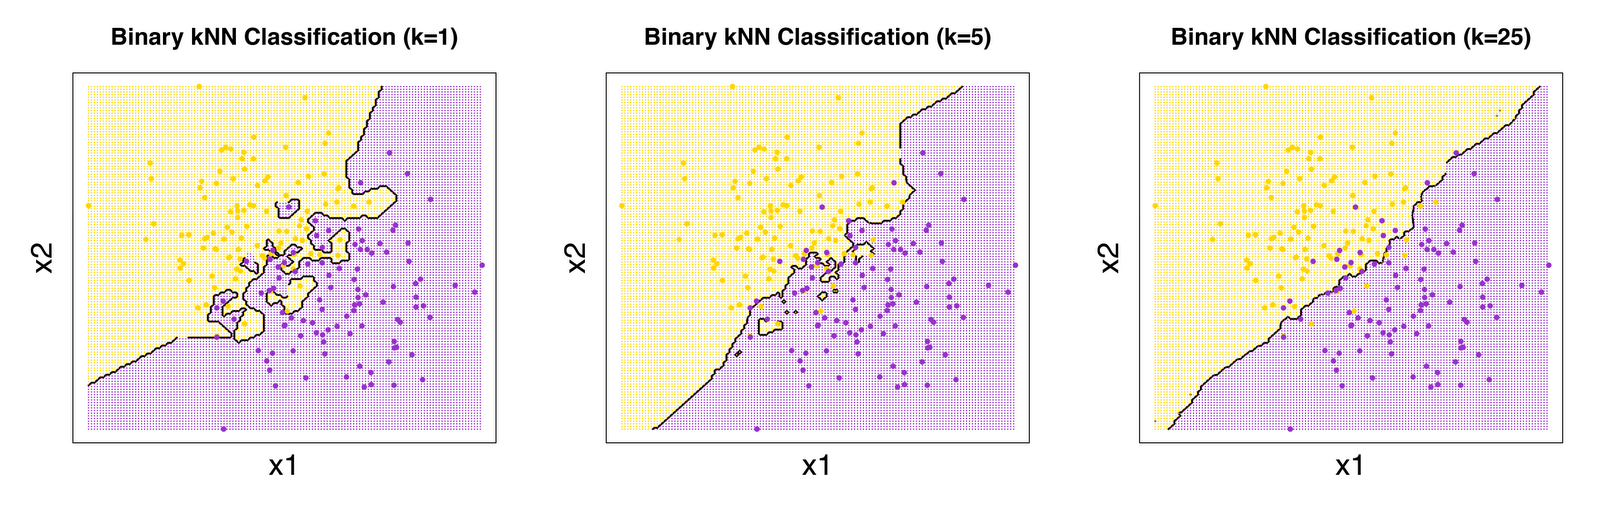

---
## BAYES

In [ ]:
X_train.head()

,edad,sexo,creatinina,LYVE1,REG1B,TFF1
152,58,F,1.19886,3.043465,37.135014,167.871849
547,60,F,0.20358,3.934431,66.462480,390.015483
443,63,F,0.64467,8.481769,170.438940,1014.291600
554,56,M,0.35061,3.872582,278.070250,0.027348
436,77,M,1.22148,5.733242,265.985020,2913.085500


In [ ]:
# Importo el modulo preprocessing de la librería sklearn, porque me interesa una función en particular --> LabelEncoder
from sklearn import preprocessing
# creo labelEncoder
le = preprocessing.LabelEncoder()
# convierto strings en números. Por ejemplo 'F'/'M' son recodificados en números
y_train_encoded=le.fit_transform(y_train)
X_train['sexo'] = le.fit_transform(X_train['sexo'])
X_test['sexo'] = le.fit_transform(X_test['sexo'])

In [ ]:
#Creo Gaussian Classifier
gnb = GaussianNB()

#Entreno
gnb.fit(X_train, y_train)

#Predigo
y_pred = gnb.predict(X_test)

In [ ]:
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.8311688311688312


In [ ]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

     maligno       1.00      0.68      0.81        40
      normal       0.74      1.00      0.85        37

    accuracy                           0.83        77
   macro avg       0.87      0.84      0.83        77
weighted avg       0.88      0.83      0.83        77

[[27 13]
 [ 0 37]]


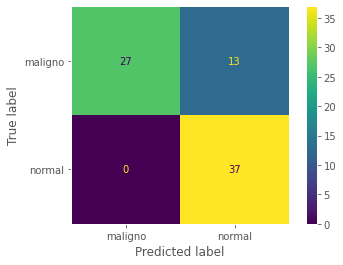

In [ ]:
disp=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred),display_labels=gnb.classes_)
disp.plot()
plt.grid(False)

Frontera de decisión

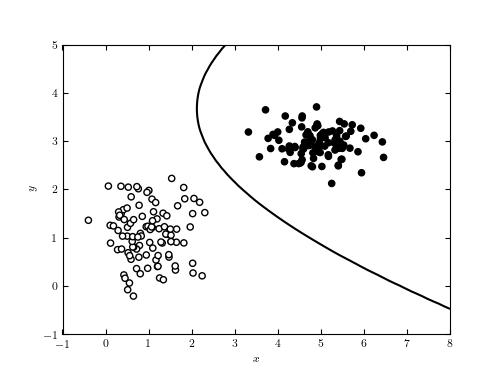

---
## ARBOLES DE DECISIÓN

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [ ]:
X_train.head()

,edad,sexo,creatinina,LYVE1,REG1B,TFF1
152,58,0,1.19886,3.043465,37.135014,167.871849
547,60,0,0.20358,3.934431,66.462480,390.015483
443,63,0,0.64467,8.481769,170.438940,1014.291600
554,56,1,0.35061,3.872582,278.070250,0.027348
436,77,1,1.22148,5.733242,265.985020,2913.085500


In [ ]:
# creo un array con la función .linspace. Me permite crear números equidistantes entre los límites que le ponga
# en este caso estoy creando 20 números entre 0 y 0.1
alfa_array = np.linspace(0, 0.1, num=20)

# defino grilla para probar parámetros ("perillas" del modelo)
params_grid2 = {'criterion':['gini'],
               'max_depth': np.random.randint(0,20,10),
               'min_samples_leaf': np.random.randint(0,10,5),
                'class_weight': ['balanced'],
               'ccp_alpha': alfa_array}

In [ ]:
%%capture
# El capture hace que no se me impriman los resultados. Lo puse porque en el grid search, hay combinaciones que no son posibles según el método
# y entonces tira error (sólo para no verlo). Me está calculando mal? No! simplemente me tira un error que dice: la cobinación de parám. max_depth = 10 y (por ejemplo)
# "min_samples_leaf = cierto valor" no son compatibles con el método y no se calcularán.
# Entre todas las combinaciones posibles, quizás me aparecen... pero a mí me interesa capturar las otras combinaciones factibles.

# Armo árbol de decisión
dtree = DecisionTreeClassifier(random_state= 19)
# Le pido que me haga una búsqueda de hiperparámetros exhaustiva (grid search)
dt = GridSearchCV(dtree, param_grid = params_grid2, cv = 3, verbose=True, n_jobs=-1)
# Ahora le pido que entrene modelo
best_dt= dt.fit(X_train,y_train)

Hiperparámetros derivados de la optimización: DecisionTreeClassifier(class_weight='balanced', max_depth=14,
                       min_samples_leaf=7, random_state=19)
Las clases del modelo son: ['maligno' 'normal']
Accuracy - : 0.908
              precision    recall  f1-score   support

     maligno       0.91      0.80      0.85        40
      normal       0.81      0.92      0.86        37

    accuracy                           0.86        77
   macro avg       0.86      0.86      0.86        77
weighted avg       0.86      0.86      0.86        77

[[32  8]
 [ 3 34]]


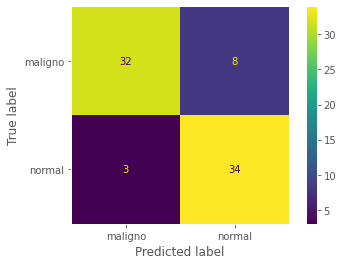

In [ ]:
# best_estimator me indica cuales son los hiperparámetros del mejor modelo
print('Hiperparámetros derivados de la optimización:', best_dt.best_estimator_)
mejor_modelo= best_dt.best_estimator_
print('Las clases del modelo son:',mejor_modelo.classes_)

print (f'Accuracy - : {best_dt.score(X_train,y_train):.3f}')

# hago predicción
y_pred = best_dt.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

disp=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred),display_labels=best_dt.classes_)
disp.plot()
plt.grid(False)


Frontera de decisión

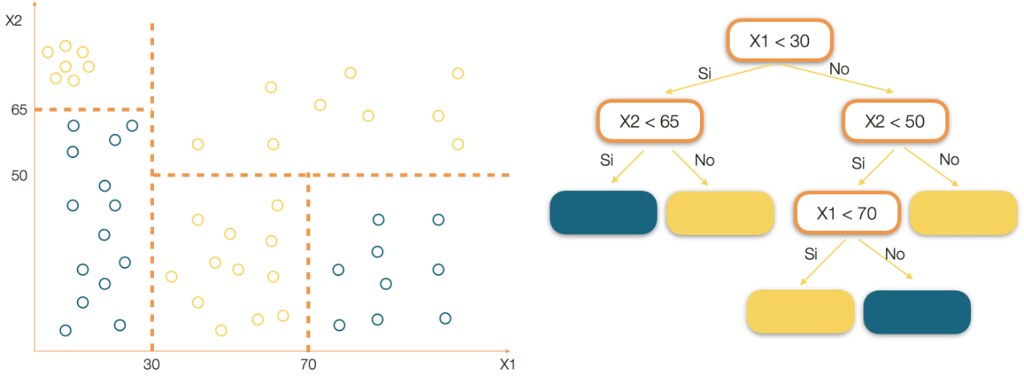

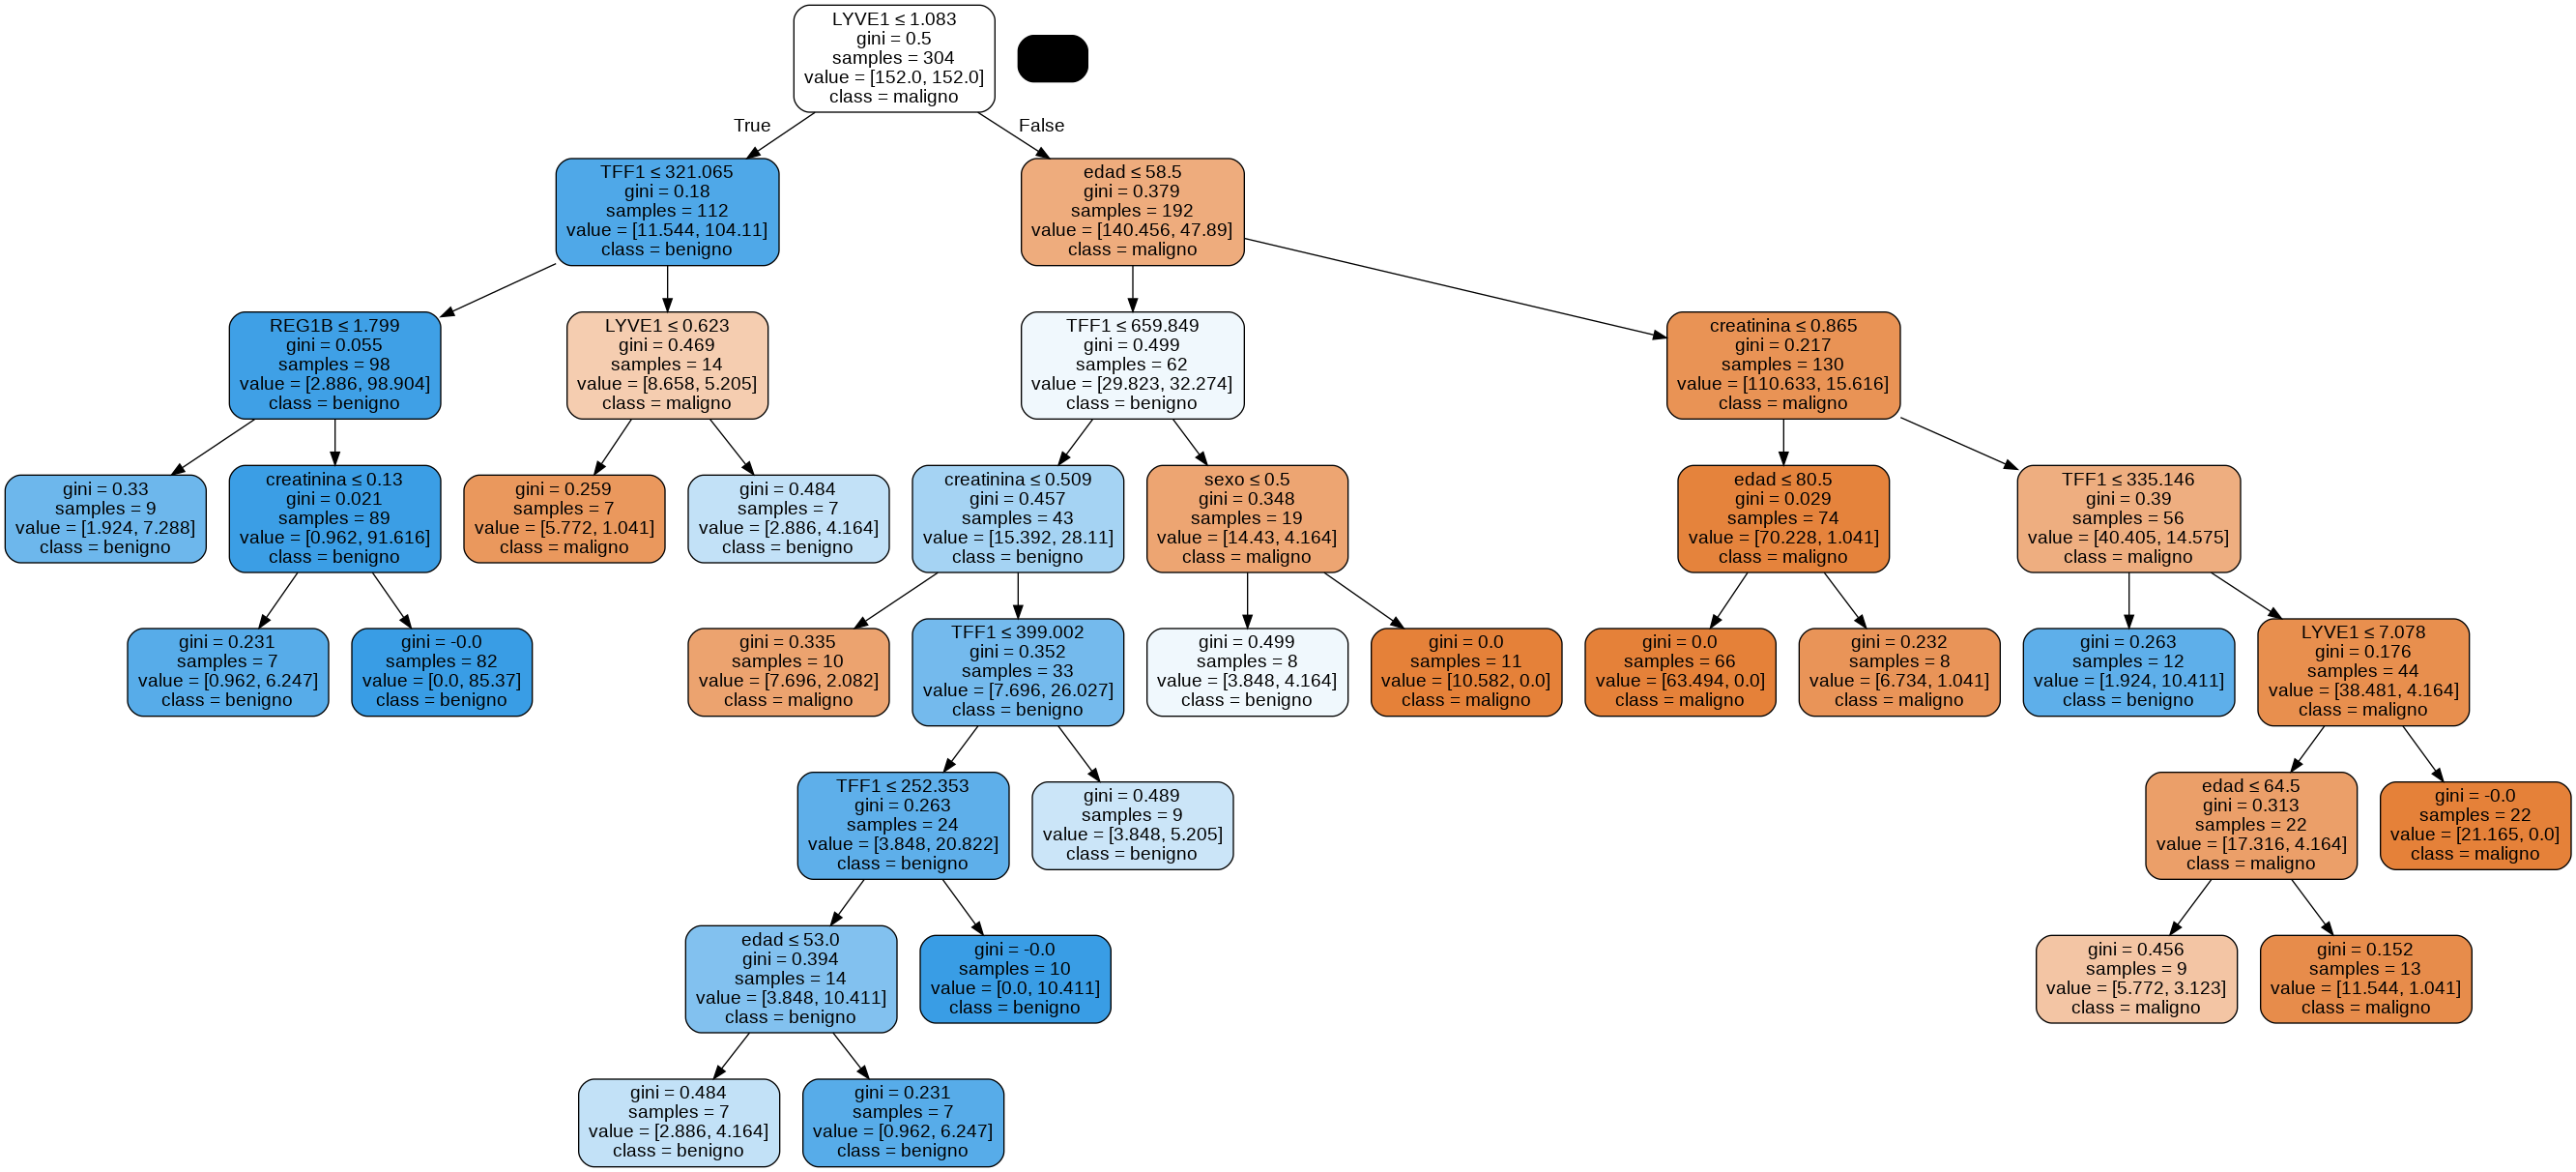

In [ ]:
# librería particular para graficar árboles de decisión

dot_data = StringIO()
export_graphviz(best_dt.best_estimator_, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
                class_names=["maligno", "benigno"],
                feature_names=X_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

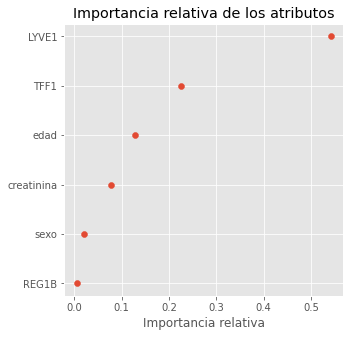

In [ ]:
features = X_train.columns

list_feat = list(zip(features, best_dt.best_estimator_.feature_importances_))
# print(sorted(list_feat))
pd_list_feat = pd.DataFrame(list_feat)
pd_list_feat.columns = ('Atributo','Importancia')
pd_list_feat = pd_list_feat.sort_values(by='Importancia')

pd_list_top = pd_list_feat[pd_list_feat['Importancia']>0]
plt.figure(figsize=(5,5))
plt.scatter(y = range(len(pd_list_top)), x = pd_list_top['Importancia'])
plt.yticks(range(len(pd_list_top)),pd_list_top['Atributo'])
plt.title("Importancia relativa de los atributos")
plt.xlabel("Importancia relativa")
plt.show()
